In [92]:
import warnings
warnings.filterwarnings("ignore")

In [211]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from sklearn.model_selection import train_test_split
from tabulate import tabulate

## Prepare train and test data sets

Prepare dataframes of the file paths for the train, test and validation data sets

In [94]:
dir_path = "./data/"
file_paths = []
labels = []
folders = os.listdir(dir_path)

In [95]:
for folder in folders:
    fold_path = dir_path + folder
    for file in os.listdir(fold_path):
        file_paths.append(fold_path + "/" + file)
        labels.append(folder)

In [96]:
df = pd.DataFrame({"file_path": file_paths, "label": labels}).sample(frac=1)
df.head()

,file_path,label
10417,./data/Parasitized/C132P93ThinF_IMG_20151004_1...,Parasitized
11335,./data/Parasitized/C118P79ThinF_IMG_20151002_1...,Parasitized
6297,./data/Parasitized/C39P4thinF_original_IMG_201...,Parasitized
4960,./data/Parasitized/C60P21thinF_IMG_20150804_10...,Parasitized
264,./data/Parasitized/C181P142ThinF_IMG_20151127_...,Parasitized


In [97]:
df.describe()

,file_path,label
count,27560,27560
unique,27560,2
top,./data/Parasitized/C132P93ThinF_IMG_20151004_1...,Parasitized
freq,1,13780


In [98]:
df.reset_index(inplace=True, drop=True)
df.head(5)

,file_path,label
0,./data/Parasitized/C132P93ThinF_IMG_20151004_1...,Parasitized
1,./data/Parasitized/C118P79ThinF_IMG_20151002_1...,Parasitized
2,./data/Parasitized/C39P4thinF_original_IMG_201...,Parasitized
3,./data/Parasitized/C60P21thinF_IMG_20150804_10...,Parasitized
4,./data/Parasitized/C181P142ThinF_IMG_20151127_...,Parasitized


In [99]:
train_df, tv_df = train_test_split(df, test_size=0.2, shuffle=True)

In [100]:
valid_df, test_df = train_test_split(tv_df, test_size=0.5, shuffle=True)

In [101]:
# Get the size of the DataFrames
print(tabulate([["train_df", len(train_df)], ["test_df", len(test_df)], ["valid_df", len(valid_df)]], headers=["df", "no of samples"]))
print(f"The total number of detected file paths is: {len(df)}")

df          no of samples
--------  ---------------
train_df            22048
test_df              2756
valid_df             2756
The total number of detected file paths is: 27560


### Plot some of the images

Get a feel of the dataset haha

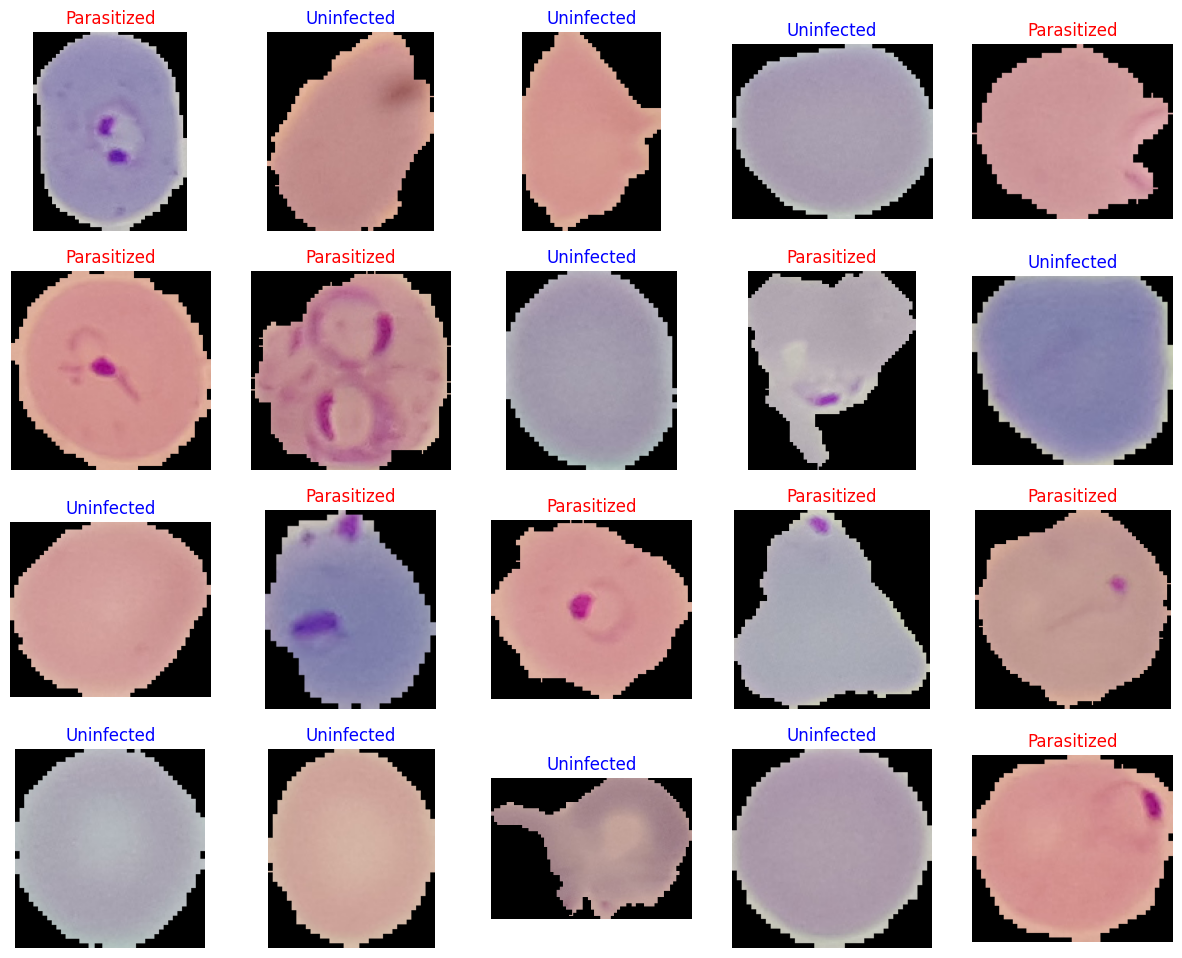

In [102]:
plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(5, 5, i+1)
    sample = train_df.sample().iloc[0]
    file_path = sample.file_path
    label = sample.label
    plt.imshow(image.load_img(file_path))
    color = "blue" if label=="Uninfected" else "red"
    plt.title(label, color=color, fontsize= 12)
    plt.axis('off')

## Train the model

In [215]:
# Get the number of classes - should be 2 (parasitized and uninfected)
K = df.label.nunique()
K

2

In [104]:
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
TRAIN_VALID_BATCH_SIZE = 64
ts_length = len(test_df)
TEST_BATCH_SIZE = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

In [105]:
gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [106]:
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col="file_path",
    y_col="label",
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE
)

Found 22046 validated image filenames belonging to 2 classes.


In [165]:
test_gen = gen.flow_from_dataframe(
    test_df,
    x_col="file_path",
    y_col="label",
    shuffle=False,
    target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE
)

Found 2756 validated image filenames belonging to 2 classes.


In [108]:
valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col="file_path",
    y_col="label",
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE
)

Found 2756 validated image filenames belonging to 2 classes.


In [109]:
base_model = MobileNetV3Large(
    input_shape=IMG_SHAPE,
    weights="imagenet",
    include_top=False
)

In [216]:
base_model.summary()

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_4[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_80       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_80[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_76 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_76[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_80[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_77 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_77[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [110]:
base_model.trainable = False

In [111]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Flatten(),
    Dense(K, activation="softmax")
])

In [117]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [119]:
epochs = 15
r = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    shuffle=False
)

Epoch 1/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 1430s 4s/step - accuracy: 0.8744 - loss: 0.4394 - val_accuracy: 0.9292 - val_loss: 0.3291
Epoch 2/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 1239s 4s/step - accuracy: 0.9348 - loss: 0.2430 - val_accuracy: 0.9412 - val_loss: 0.2118
Epoch 3/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 919s 3s/step - accuracy: 0.9474 - loss: 0.1675 - val_accuracy: 0.9488 - val_loss: 0.1580
Epoch 4/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 878s 3s/step - accuracy: 0.9527 - loss: 0.1423 - val_accuracy: 0.9503 - val_loss: 0.1499
Epoch 5/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.9564 - loss: 0.1279 - val_accuracy: 0.9546 - val_loss: 0.1432
Epoch 6/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - accuracy: 0.9560 - loss: 0.1287 - val_accuracy: 0.9543 - val_loss: 0.1246
Epoch 7/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 874s 3s/step - accuracy: 0.9551 - loss: 0.1216 - val_accuracy: 0.9568 - val_loss: 0.1265
Epoch 8/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 879s 3s/step - accuracy: 0.9578 - loss: 0.1215 - val_ac

## Model Evaluation

In [120]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 960)      │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7, 7, 256)      │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │        25,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,817,352 (14.56 MB)

 Trainable params: 273,026 (1.04 MB)

 Non-trainable params: 2,998,272 (11.44 MB)

 Optimizer params: 546,054 (2.08 MB)

In [195]:
tr_acc = r.history['accuracy']
tr_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']
best_loss_index = np.argmin(val_loss)
val_lowest = val_loss[best_loss_index]
best_train_acc_index = np.argmax(val_acc)
acc_highest = val_acc[best_train_acc_index]
epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

#### Plot train history

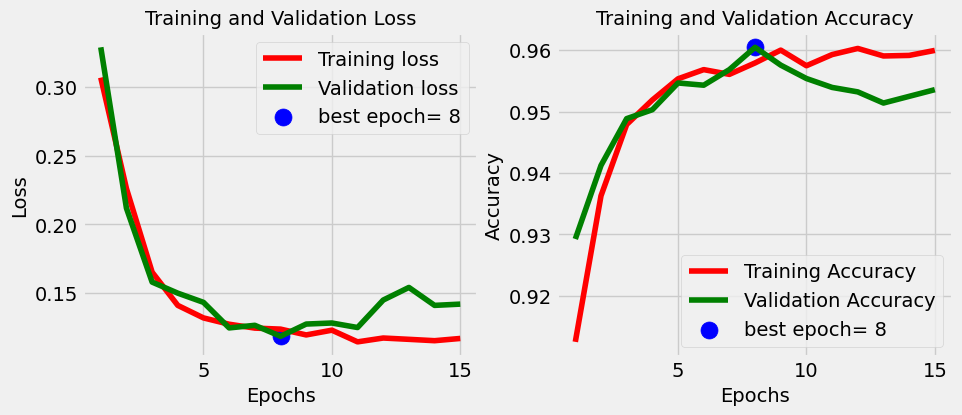

In [202]:
plt.figure(figsize= (10, 4))
plt.style.use('fivethirtyeight')

# Plot training and validation losses 
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend();

In [166]:
test_length = len(test_df)
steps = test_length // TEST_BATCH_SIZE
test_score = model.evaluate(test_gen, steps=steps)

52/52 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9560 - loss: 0.1268


In [185]:
print(f"Test loss: {test_score[0]: .06f}")
print(f"Test accuracy: {round(test_score[1]*100)}%") 

Test loss:  0.131828
Test accuracy: 96%


### Generate confusion matrix and classification report

In [168]:
Yhat = np.argmax(model.predict(test_gen), axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step


In [180]:
Ytrue = test_gen.classes
labels = list(test_gen.class_indices.keys())

#### Confusion matrix

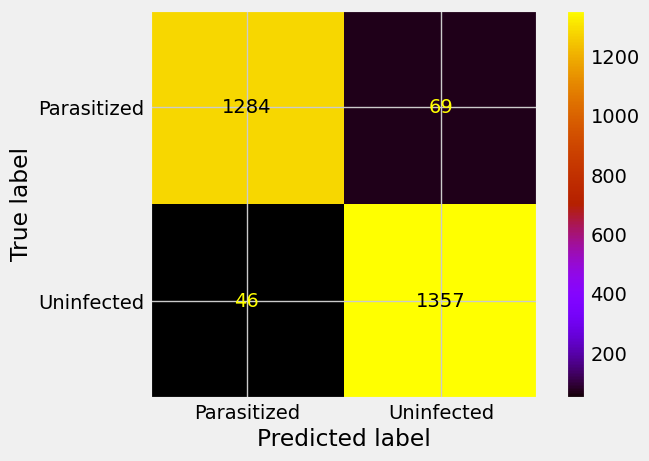

In [181]:
cm = confusion_matrix(y_true=np.array(Ytrue).flatten(), y_pred=Yhat.flatten())
display = ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices)
display.plot(cmap="gnuplot");

#### Classification report

In [214]:
print(classification_report(y_true=Ytrue, y_pred=Yhat, target_names=labels))

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      1353
  Uninfected       0.95      0.97      0.96      1403

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



## Save the model

In [208]:
model.save("malaria_diagnosis_mobilenetv3.keras")